In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pickle

In [3]:
df = pd.read_parquet('processed_data/housing_price_dataset.parquet')

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into train (60%) and temporary set (40%)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=1)

# Split the temporary set into validation (50%) and test (50%) sets
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1)

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

y_train = train_df.Price.values
y_valid = valid_df.Price.values
y_test = test_df.Price.values

full_train_df = train_df.copy()
full_valid_df = valid_df.copy()
full_test_df = test_df.copy()

del train_df["Price"]
del valid_df["Price"]
del test_df["Price"]

In [13]:
categorical_columns = ["Neighborhood"]
numerical_columns = ["SquareFeet", "Bedrooms", "YearBuilt"]

In [16]:
print(train_df[categorical_columns + numerical_columns].shape, test_df[categorical_columns + numerical_columns].shape, valid_df[categorical_columns + numerical_columns].shape)

(29964, 4) (9989, 4) (9988, 4)


In [17]:
dv = DictVectorizer(sparse=False)


train_dict = train_df[categorical_columns + numerical_columns].to_dict(orient="records")

valid_dict = valid_df[categorical_columns + numerical_columns].to_dict(orient="records")

test_dict = test_df[categorical_columns + numerical_columns].to_dict(orient="records")

X_train = dv.fit_transform(train_dict)
X_valid = dv.transform(valid_dict)
X_test = dv.transform(test_dict)

In [18]:
with open("dict_vectorizer.pkl", "wb") as f:
    pickle.dump(dv, f)

In [19]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split

# Assuming your data is already prepared and split into X_train, X_valid, y_train, y_valid

# Define the parameter grid
param_grid = {
    "colsample_bytree": [0.3, 0.5, 0.7],
    "learning_rate": [0.05, 0.1, 0.15],
    "max_depth": [3, 5, 7],
    "alpha": [5, 10, 15],
    "n_estimators": [10, 50, 100],
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=3,
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best performing model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV 1/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=10;, score=-4887583209.174 total time=   0.0s
[CV 2/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=10;, score=-4892764952.589 total time=   0.0s
[CV 3/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=10;, score=-4949699107.921 total time=   0.0s
[CV 1/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=50;, score=-3780600953.890 total time=   0.1s
[CV 2/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=50;, score=-3785946599.625 total time=   0.0s
[CV 3/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=50;, score=-3853726759.772 total time=   0.0s
[CV 1/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=100;, score=-2857608612.071 tot

In [20]:
best_params = grid_search.best_params_

print("Best parameters found:", best_params)

Best parameters found: {'alpha': 10, 'colsample_bytree': 0.5, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 50}


In [26]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Hyperparameters to tune
model_params = {
    "Ridge": {"alpha": [1, 10, 100]},
    "Lasso": {"alpha": [0.001, 0.01, 0.1, 1]},
    "ElasticNet": {"alpha": [0.001, 0.01, 0.1, 1], "l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"n_estimators": [10, 50, 100], "max_depth": [None, 10, 20]},
    "GradientBoosting": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]},
    "SVR": {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"]},
    "KNN": {"n_neighbors": [3, 5, 11], "weights": ["uniform", "distance"]},
    "XGBoost": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.15]},
}

# Model initialization
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(),
}

# Dictionary to hold model scores
scores = {}

# Loop to train, tune, and evaluate each model
for model_name, model in models.items():
    # Grid Search setup
    param = model_params.get(model_name, {})
    grid = GridSearchCV(model, param, cv=5, scoring="neg_mean_squared_error")

    # Train and Tune the model
    grid.fit(X_train, y_train)

    # Best parameters
    best_params = grid.best_params_

    # Evaluate on the validation set
    valid_pred = grid.predict(X_valid)
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))

    # Evaluate on the test set
    test_pred = grid.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    # Store the scores
    scores[model_name] = {
        "Best Parameters": best_params,
        "Validation RMSE": valid_rmse,
        "Test RMSE": test_rmse,
    }

    # Print the scores
    print(f"{model_name}:")
    print(f"  Best Parameters: {best_params}")
    print(f"  Validation RMSE: {valid_rmse}")
    print(f"  Test RMSE: {test_rmse}\n")

# Print all scores for comparison
print("All Scores:")
print(scores)

Ridge:
  Best Parameters: {'alpha': 100}
  Validation RMSE: 49736.14049891102
  Test RMSE: 49719.90572023312

Lasso:
  Best Parameters: {'alpha': 1}
  Validation RMSE: 49736.29500557646
  Test RMSE: 49719.966565445655



/Users/inristaka/.local/share/virtualenvs/capstone-project-1-eHKANpzW/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e+13, tolerance: 1.380e+10
  model = cd_fast.enet_coordinate_descent(
/Users/inristaka/.local/share/virtualenvs/capstone-project-1-eHKANpzW/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.737e+12, tolerance: 1.390e+10
  model = cd_fast.enet_coordinate_descent(
/Users/inristaka/.local/share/virtualenvs/capstone-project-1-eHKANpzW/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did no

ElasticNet:
  Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.8}
  Validation RMSE: 49735.45345947759
  Test RMSE: 49719.697794725456

RandomForest:
  Best Parameters: {'max_depth': 10, 'n_estimators': 100}
  Validation RMSE: 50151.3532517512
  Test RMSE: 50153.19597036967

GradientBoosting:
  Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
  Validation RMSE: 49795.007138832036
  Test RMSE: 49782.32673941409

SVR:
  Best Parameters: {'C': 10, 'kernel': 'linear'}
  Validation RMSE: 49736.2721131457
  Test RMSE: 49731.98759095667

KNN:
  Best Parameters: {'n_neighbors': 11, 'weights': 'uniform'}
  Validation RMSE: 52097.36685557628
  Test RMSE: 52097.73901353914

XGBoost:
  Best Parameters: {'learning_rate': 0.01, 'n_estimators': 200}
  Validation RMSE: 50524.660810844296
  Test RMSE: 50144.92836847201

All Scores:
{'Ridge': {'Best Parameters': {'alpha': 100}, 'Validation RMSE': 49736.14049891102, 'Test RMSE': 49719.90572023312}, 'Lasso': {'Best Parameters': {'alpha': 1}, 'Val

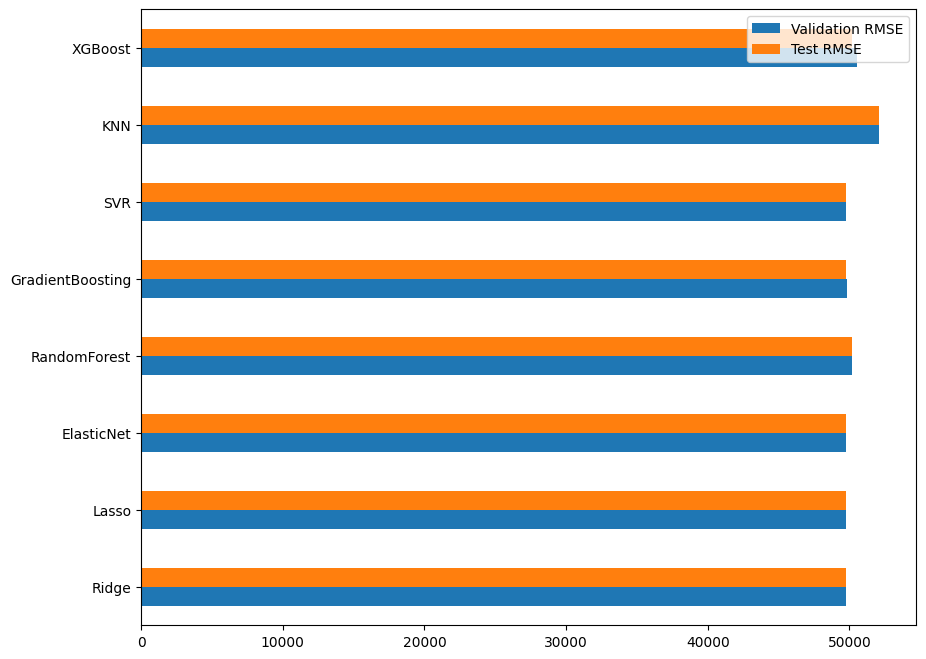

In [27]:
# Plot the scores for comparison
scores_df = pd.DataFrame(scores).T
scores_df = scores_df[["Validation RMSE", "Test RMSE"]]
scores_df.plot(kind="barh", figsize=(10, 8))
plt.show()

In [28]:
# Save the best model
best_model = grid_search.best_estimator_

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [36]:
y_pred = best_model.predict(X_valid)

residuals = y_valid - y_pred

In [37]:
print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of y_test: {y_valid.shape}")

Shape of y_pred: (9988,)
Shape of y_test: (9988,)


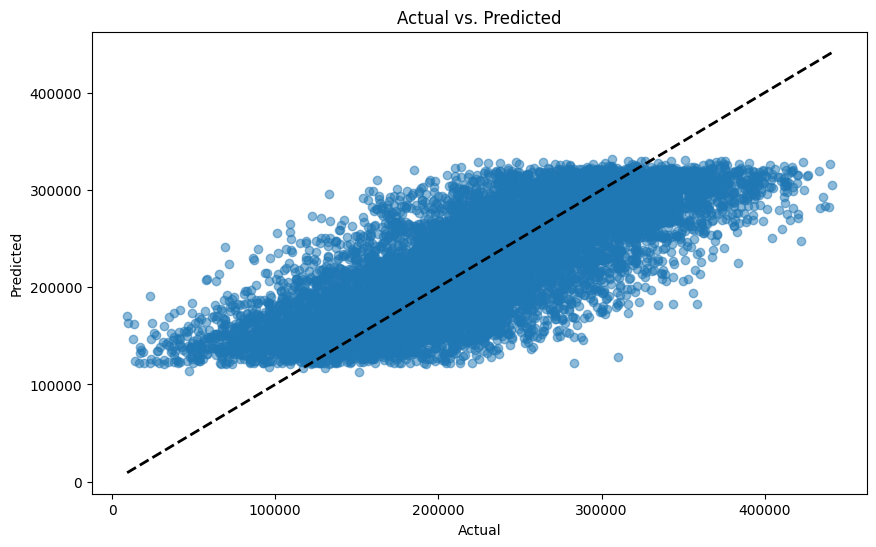

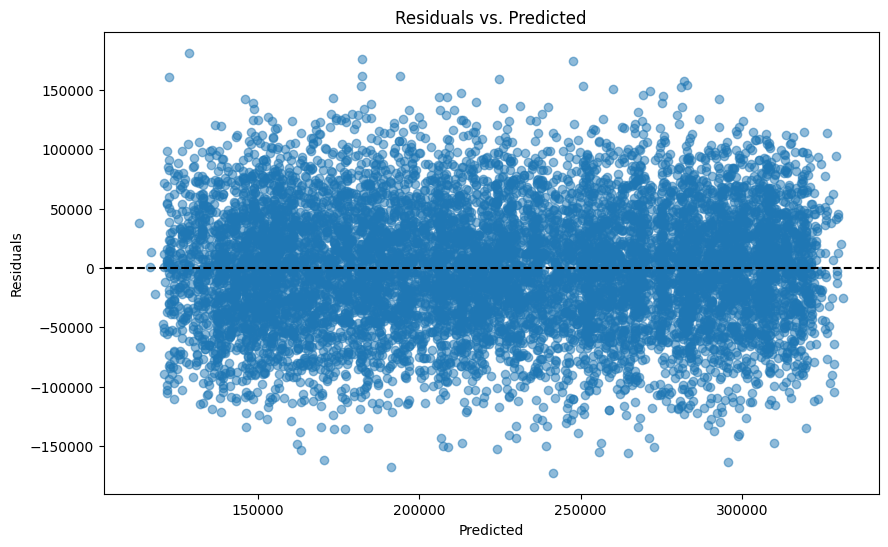

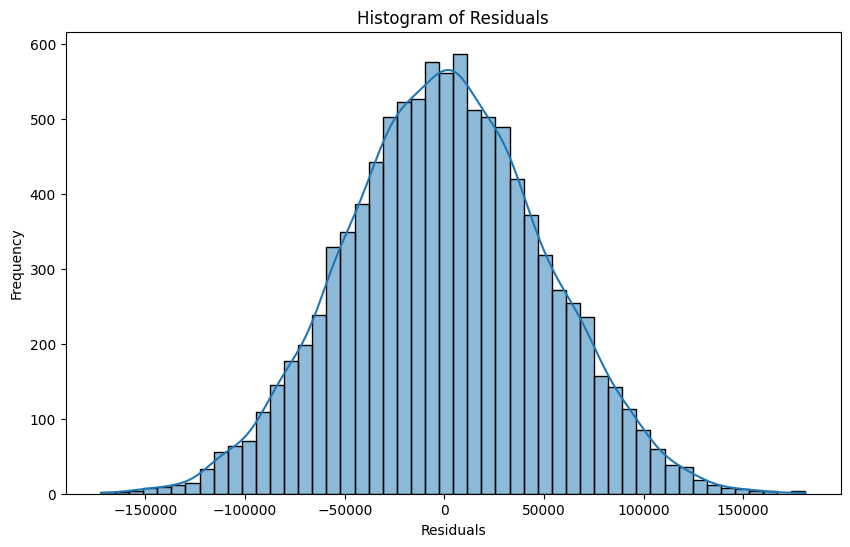

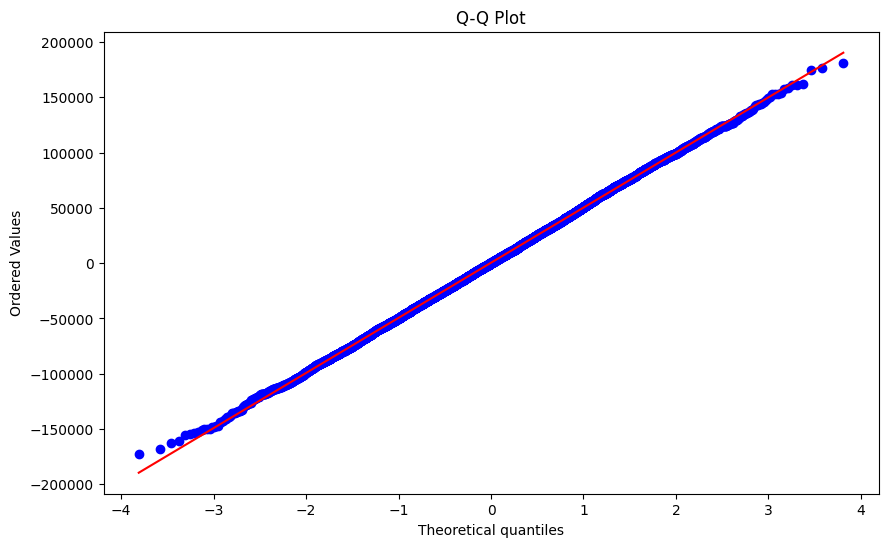

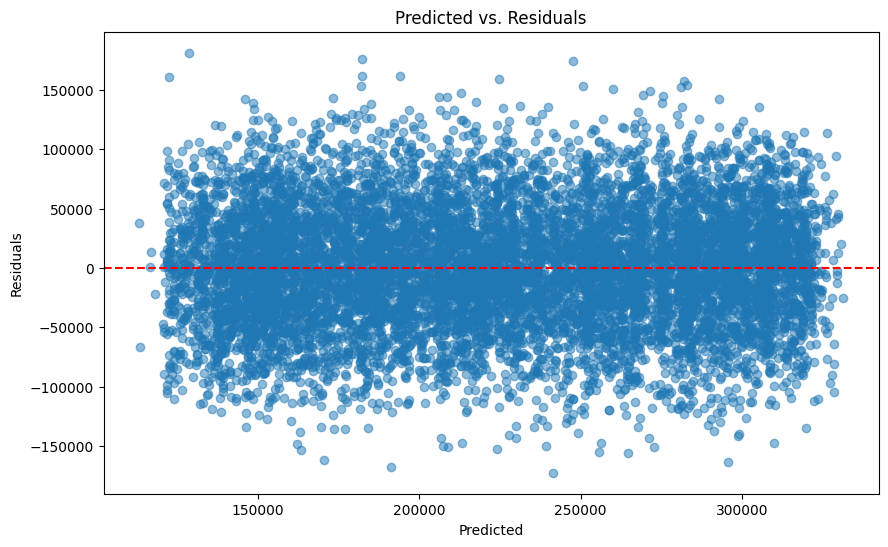

In [38]:


# 1. Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], "k--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()

# 2. Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="k", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 4. Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

# 5. Predicted vs. Residuals Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.title("Predicted vs. Residuals")
plt.show()